In [48]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import corner
from numpy.polynomial.chebyshev import Chebyshev


In [2]:
# Define the path to the allStar catalog
allstar_file = 'lab2_data/allStar-dr17-synspec_rev1.fits'

# Open the FITS file and read the data
with fits.open(allstar_file) as hdulist:
    data = Table(hdulist[1].data)

In [ ]:
# List of fields of interest
fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']

# Filter data based on the 'FIELD' column
data_filtered = data[np.isin(data['FIELD'], fields)]

# Create a mask for entries with all required labels present
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
mask = np.ones(len(data_filtered), dtype=bool)
for label in labels:
    mask &= ~np.isnan(data_filtered[label])

data_filtered = data_filtered[mask]

# Apply SNR >= 50 cut
data_filtered = data_filtered[data_filtered['SNR'] >= 50]

# Exclude stars with LOGG > 4 or TEFF > 5700 K
data_filtered = data_filtered[(data_filtered['LOGG'] <= 4) & (data_filtered['TEFF'] <= 5700)]

# Exclude stars with FE_H < -1
data_filtered = data_filtered[data_filtered['FE_H'] >= -1]

print(f"Total number of stars: {len(data_filtered)}")

# Save the filtered Astropy Table to a FITS file
data_filtered.write('lab2_data/filtered_training_set.fits', overwrite=True)

print("Filtered Astropy Table saved to 'lab2_data/filtered_training_set.fits'")

In [3]:
def load_filtered_training_set(filepath='lab2_data/filtered_training_set.fits'):
    data_filtered = Table.read(filepath)
    return data_filtered

data_filtered = load_filtered_training_set()

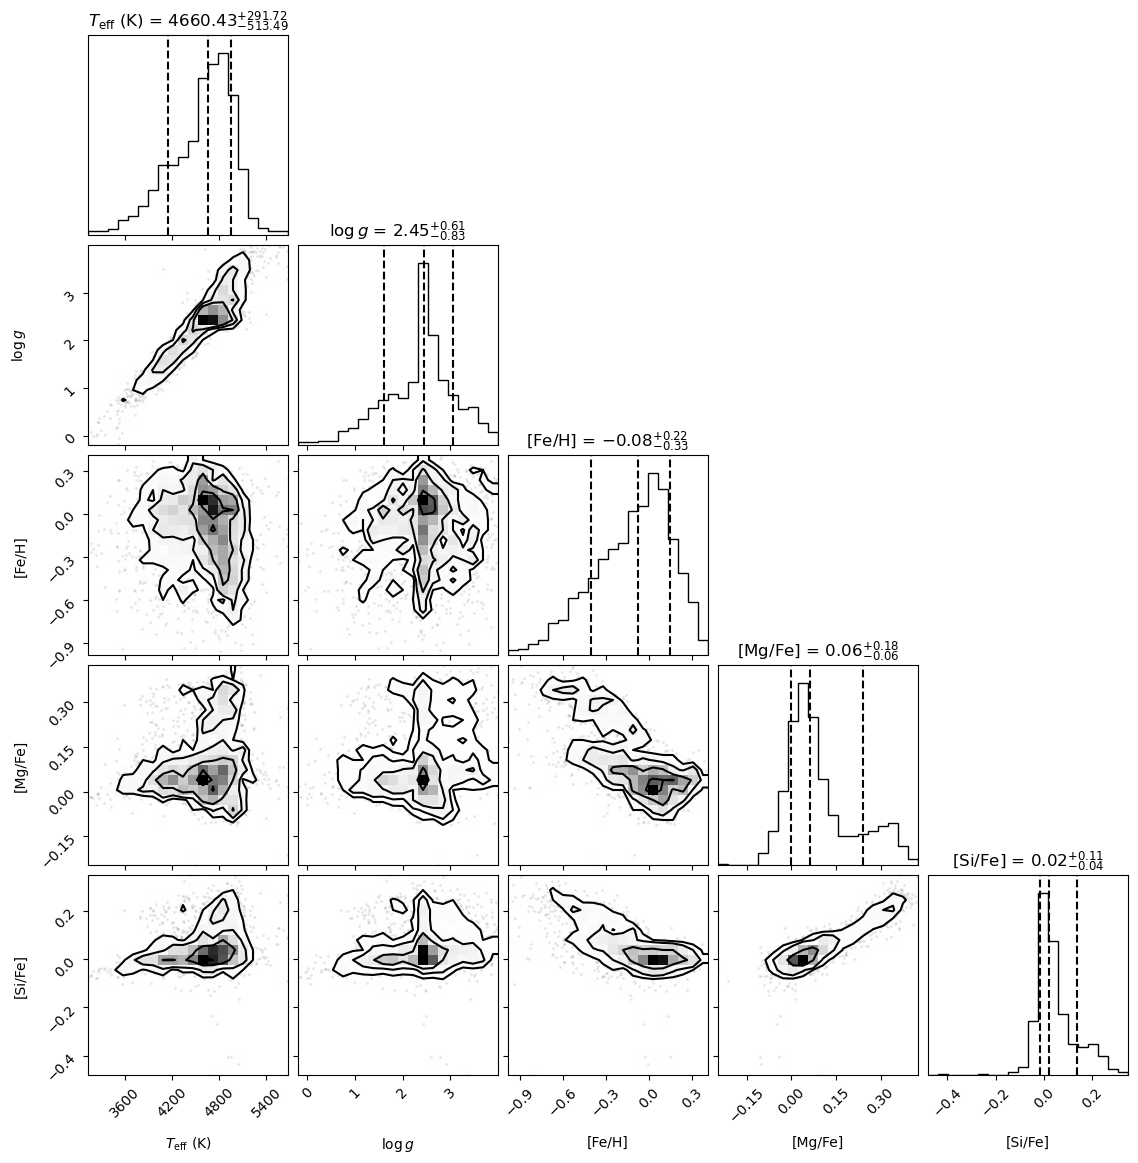

In [5]:
# Extract the labels for plotting
labels_to_plot = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
label_data = np.vstack([data_filtered[label] for label in labels_to_plot]).T

# Define labels for the plot
plot_labels = [r'$T_{\mathrm{eff}}$ (K)', r'$\log g$', r'[Fe/H]', r'[Mg/Fe]', r'[Si/Fe]']

# Create the corner plot
figure = corner.corner(
    label_data,
    labels=plot_labels,
    show_titles=True,
    title_fmt='.2f',
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12}
)
plt.show()

In [6]:
# Define the base URLs
aspcap_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1"
apstar_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars"

# Extract the relevant columns from the filtered data
apogee_ids = data_filtered['APOGEE_ID']
telescopes = data_filtered['TELESCOPE']
fields = data_filtered['FIELD']

# Define the folder to save the spectra
output_folder = "lab2_data/apStar_spectra"
os.makedirs(output_folder, exist_ok=True)

# Function to download a file from a given URL
def download_spectra(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed to download: {url}")

# Loop over the filtered data and construct the URLs
for apogee_id, telescope, field in zip(apogee_ids, telescopes, fields):
    # Construct the apStar file URL
    apstar_url = f"{apstar_base_url}/{telescope}/{field}/apStar-dr17-{apogee_id}.fits"
    apstar_filename = os.path.join(output_folder, f"apStar-dr17-{apogee_id}.fits")
    
    # Download the apStar file
    download_spectra(apstar_url, apstar_filename)

Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03501997+2458304.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03502656+2445432.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03504772+2514178.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03504852+2433483.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03505216+2442325.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03510670+2523599.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03510864+2511250.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03510934+2503195.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03511378+2511479.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03511409+2452377.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03512380+2417373.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03512398+2451450.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M03512408+2544430.fits
Downloaded: lab2_data/apStar_spectra/apStar-dr17-2M

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

Flux shape before processing: (4, 8575)
Flux shape after flattening: (34300,)


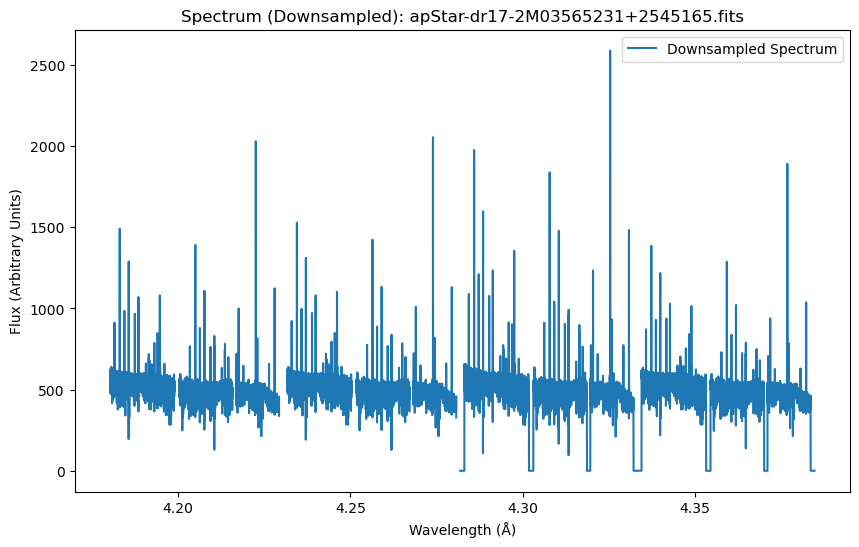

In [28]:
downloaded_files = os.listdir(output_folder)

def plot_apstar_spectrum(apstar_filename, downsample_factor=1):
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux (multi-visit spectrum)
        flux = hdulist[1].data  # Coadded flux data is in the second HDU
        header = hdulist[1].header  # Header contains necessary metadata
        
        # Debug: Check the shape of flux
        print("Flux shape before processing:", flux.shape)
        
        # Handle multi-dimensional flux data
        if flux.ndim > 1:
            # Option 1: Flatten the flux array
            flux = flux.flatten()
            # Option 2: Select a specific spectrum
            # flux = flux[0]  # Uncomment and adjust index if needed
            print("Flux shape after flattening:", flux.shape)
        
        # Reconstruct the wavelength array
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)     # Number of flux points (pixels)
        wavelength = crval + cdelt * np.arange(num_pixels)

        # Downsample the data by averaging over groups of points
        downsampled_wavelength = wavelength[::downsample_factor]
        downsampled_flux = flux[::downsample_factor]

        # Plot downsampled flux vs wavelength
        plt.figure(figsize=(10, 6))
        plt.plot(downsampled_wavelength, downsampled_flux, label='Downsampled Spectrum')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux (Arbitrary Units)')
        plt.title(f'Spectrum (Downsampled): {os.path.basename(apstar_filename)}')
        plt.legend()
        plt.show()

apstar_file_path = os.path.join(output_folder, downloaded_files[0])
plot_apstar_spectrum(apstar_file_path)


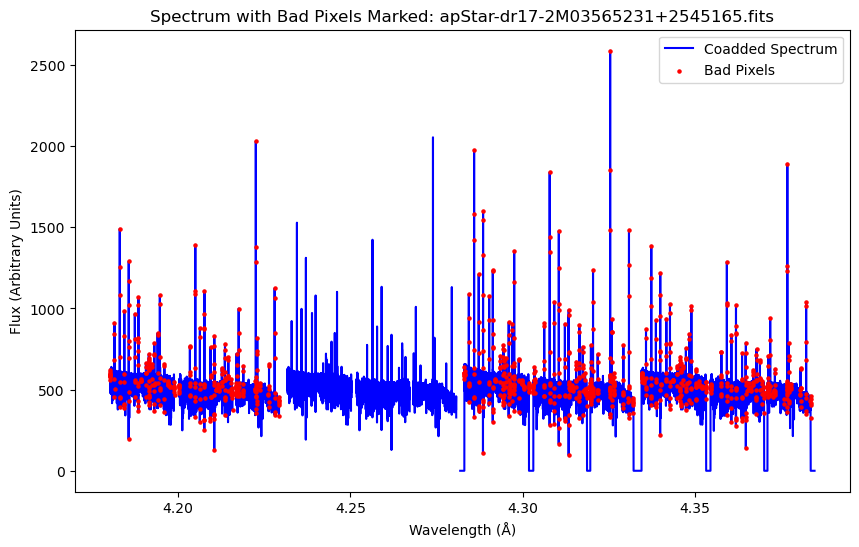

In [41]:
def process_spectrum_with_bitmask(apstar_filename, large_error_value=1e10):
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux, error (uncertainty), and mask (bitmask)
        flux = hdulist[1].data  # Coadded flux data
        error = hdulist[2].data  # Uncertainty (error) array
        bitmask = hdulist[3].data  # Bitmask array
        
        # Handle multi-dimensional flux data if necessary
        if flux.ndim > 1:
            flux = flux.flatten()
            error = error.flatten()
            bitmask = bitmask.flatten()

        # Define the bits we're interested in (bit positions for BADPIX, CRPIX, SATPIX, etc.)
        bad_bits_mask = (
            (bitmask & (1 << 0)) |   # BADPIX
            (bitmask & (1 << 1)) |   # CRPIX
            (bitmask & (1 << 2)) |   # SATPIX
            (bitmask & (1 << 3)) |   # UNFIXABLE
            (bitmask & (1 << 4)) |   # BADDARK
            (bitmask & (1 << 5)) |   # BADFLAT
            (bitmask & (1 << 6)) |   # BADERR
            (bitmask & (1 << 7)) |   # NOSKY
            (bitmask & (1 << 12))    # SIG_SKYLINE
        )
        
        # Identify bad pixels (where any of the relevant bits are set)
        bad_pixel_mask = bad_bits_mask > 0
        
        # Set uncertainty of bad pixels to a large value
        error[bad_pixel_mask] = large_error_value

        # Reconstruct the wavelength array from the header
        header = hdulist[1].header
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)
        wavelength = crval + cdelt * np.arange(num_pixels)

        # Plot the spectrum (flux) first
        plt.figure(figsize=(10, 6))
        plt.plot(wavelength, flux, label='Coadded Spectrum', color='blue', zorder=1)

        # Plot the bad pixels on top in red
        plt.scatter(wavelength[bad_pixel_mask], flux[bad_pixel_mask], color='red', s=5, label='Bad Pixels', zorder=2)

        # Set labels and title
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux (Arbitrary Units)')
        plt.title(f'Spectrum with Bad Pixels Marked: {os.path.basename(apstar_filename)}')
        plt.legend()
        plt.show()

        # Return processed flux, error, and bad pixel mask
        return flux, error, bad_pixel_mask

# Example usage: Process the first apStar file and plot the results
apstar_file_path = os.path.join(output_folder, downloaded_files[0])
flux, error, bad_pixel_mask = process_spectrum_with_bitmask(apstar_file_path)


In [42]:
# Count the number of bad bits (bad pixels)
num_bad_bits = np.sum(bad_pixel_mask)

# Print the result
print(f"Number of bad bits (bad pixels): {num_bad_bits}")


Number of bad bits (bad pixels): 1082


In [70]:
def load_continuum_pixels(filename):
    """Load the continuum pixels from the provided file."""
    continuum_data = np.load(filename)
    return continuum_data['trusted']  # Use 'trusted' key for continuum pixels

def fit_chebyshev_polynomial(wavelength, flux, continuum_pixels, degree=2):
    """Fit a Chebyshev polynomial to the continuum pixels."""
    # Select the continuum pixels
    continuum_wavelength = wavelength[continuum_pixels]
    continuum_flux = flux[continuum_pixels]
    
    # Fit a Chebyshev polynomial of the given degree
    cheb_fit = Chebyshev.fit(continuum_wavelength, continuum_flux, degree)
    
    # Use the fitted polynomial to estimate the continuum across all wavelengths
    continuum_estimated = cheb_fit(wavelength)
    
    return continuum_estimated

def normalize_spectrum(apstar_filename, continuum_pixels_filename):
    # Load the continuum pixels (boolean mask)
    continuum_pixels = load_continuum_pixels(continuum_pixels_filename)
    
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux and wavelength information
        flux = hdulist[1].data
        header = hdulist[1].header
        
        # Debug: Check the shape of the flux array
        print("Original flux shape:", flux.shape)
        
        # Reconstruct the wavelength array from the header
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)
        wavelength = crval + cdelt * np.arange(num_pixels)
        
        # Debug: Check the wavelength array length
        print("Wavelength array length:", len(wavelength))
        
        # Handle multi-dimensional flux data if necessary
        if flux.ndim > 1:
            # Flatten the flux array if necessary
            flux = flux.flatten()
            print("Flattened flux shape:", flux.shape)
        
        # Ensure the continuum pixels are correctly matched to the wavelength range
        if len(continuum_pixels) != len(wavelength):
            raise ValueError(f"Continuum pixel mask length ({len(continuum_pixels)}) does not match number of flux points ({len(wavelength)}).")
        
        # Estimate the continuum for each of the three chips separately
        # Chip 1: 15150–15800 Å, Chip 2: 15890–16430 Å, Chip 3: 16490–16950 Å
        chip1_mask = (wavelength >= 15150) & (wavelength <= 15800)
        chip2_mask = (wavelength >= 15890) & (wavelength <= 16430)
        chip3_mask = (wavelength >= 16490) & (wavelength <= 16950)
        
        # Fit Chebyshev polynomial to each chip, using only continuum pixels for each chip
        continuum_chip1 = fit_chebyshev_polynomial(wavelength[chip1_mask], flux[chip1_mask], continuum_pixels[chip1_mask])
        continuum_chip2 = fit_chebyshev_polynomial(wavelength[chip2_mask], flux[chip2_mask], continuum_pixels[chip2_mask])
        continuum_chip3 = fit_chebyshev_polynomial(wavelength[chip3_mask], flux[chip3_mask], continuum_pixels[chip3_mask])
        
        # Combine the continuum estimates from all three chips
        continuum = np.zeros_like(flux)
        continuum[chip1_mask] = continuum_chip1
        continuum[chip2_mask] = continuum_chip2
        continuum[chip3_mask] = continuum_chip3
        
        # Normalize the flux by dividing by the continuum estimate
        normalized_flux = flux / continuum
        
        # Plot the un-normalized flux, the estimated continuum, and the normalized flux
        plt.figure(figsize=(10, 6))
        plt.plot(wavelength, flux, label='Un-normalized Spectrum', color='blue')
        plt.plot(wavelength, continuum, label='Estimated Continuum', color='green')
        plt.plot(wavelength, normalized_flux, label='Normalized Spectrum', color='red')
        plt.xlabel('Wavelength (Å)')
        plt.ylabel('Flux')
        plt.title('Spectrum Normalization')
        plt.legend()
        plt.show()

        return normalized_flux

# Example usage: Normalize a spectrum
apstar_file_path = os.path.join(output_folder, downloaded_files[0])  # Path to an example apStar file
continuum_pixels_file_path = 'lab2_data/cannon_continuum_apogee.npz'  # Path to the continuum pixels file
normalized_flux = normalize_spectrum(apstar_file_path, continuum_pixels_file_path)


OSError: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True

In [53]:
# Inspect the structure of the 'trusted' continuum pixels
continuum_pixels = load_continuum_pixels(continuum_pixels_file_path)
print(continuum_pixels.shape)
print(continuum_pixels)


(7214,)
[False False False ... False False False]
